# BAYa class Assignment 2019

In this assignment, your task will be to implement and analyze inference in Bayesian Gaussian Mixture Model (GMM) as described in the slides on [Approximate Inference in Bayesian Models](http://www.fit.vutbr.cz/study/courses/BAYa/public/prednasky/4-Approximate%20inference.pdf). The preferred and easiest way of accomplishing this task is to complete this Jupyter Notebook, which already comes with training data definition and a code for Maximum Likelihood (ML) training of a contrastive GMM system. If you do not have any experience with Jupyter Notebook, the easiest way to start is to install Anaconda3, run Jupyter Notebook and open this notebook downloaded from [BAYa_Assignment2019.ipynb](http://www.fit.vutbr.cz/study/courses/BAYa/public/notebooks/BAYa_Assignment2019.ipynb). You can also benefit from reusing pieces of code from the Jupyter Notebooks provided for this class, namely: [vb_gmm_training.ipynb](http://www.fit.vutbr.cz/study/courses/BAYa/public/notebooks/vb_gmm_training.ipynb) and [gs_gmm_training.ipynb](http://www.fit.vutbr.cz/study/courses/BAYa/public/notebooks/gs_gmm_training.ipynb).


The following cell contains a code with the definition of training data and the contrastive system training. You should not edit this part! The code does the following:

1. We "handcraft" a GMM (i.e. define GMM parameters) with 4 Gaussian components, which represents the "true distribution" of training data.
2. We have pre-generated training data from this GMM (see definition of variable x), so that everyone works with exactly the same data.
3. GMM with C=6 components is trained on the training data using ML training (the standard EM algorithm). You will use this GMM as a contrastive model. You will compare it to your implementation of VB GMM.
4. The following plots are made:
 * The true training data distribution (in grey).
 * The training observation generated from this true GMM (black + at the x axis).
 * The ML GMM estimate obtained using the EM algorithm (in black)
 $$
\DeclareMathOperator{\aalpha}{\boldsymbol{\alpha}}
\DeclareMathOperator{\bbeta}{\boldsymbol{\beta}}
\DeclareMathOperator{\NN}{\mathbf{N}}
\DeclareMathOperator{\ppi}{\boldsymbol{\pi}}
\DeclareMathOperator{\mmu}{\boldsymbol{\mu}}
\DeclareMathOperator{\llambda}{\boldsymbol{\lambda}}
\DeclareMathOperator{\diff}{\mathop{}\mathrm{d}}
\DeclareMathOperator{\zz}{\mathbf{z}}
\DeclareMathOperator{\XX}{\mathbf{X}}
\DeclareMathOperator{\xx}{\mathbf{x}}
\DeclareMathOperator{\YY}{\mathbf{Y}}
\DeclareMathOperator{\NormalGamma}{\mathcal{NG}}
$$

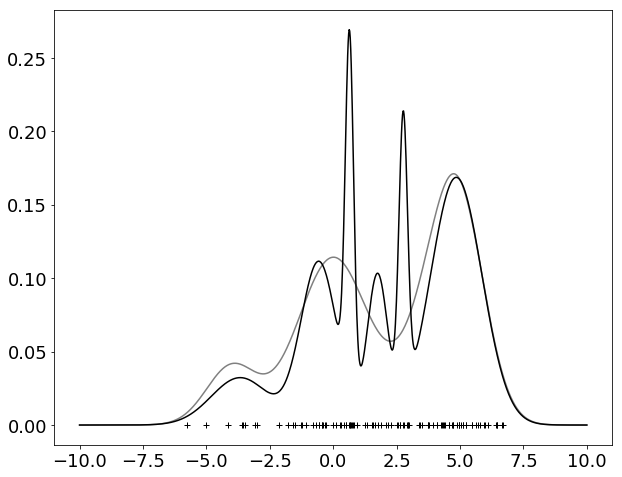

In [18]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
from scipy.special import logsumexp
from scipy.special import digamma
%matplotlib inline 
#%matplotlib qt5 #get an extra window for the plots
plt.rcParams.update({'figure.figsize': (10.0, 8.0), 'font.size': 18}) #Make the plots bigger


def GMM_pdf(x, mus, vars, pis):
  # Function for evaluating univariate GMM at values given by vector 'x'
  # 'mus', 'vars', 'pis' are vectors of means, variances and weights of individual Gaussian components
  # 'x[:,np.newaxis]' makes 'x' column vector to evaluate every coefficient of 'x' w.r.t. every Gaussian
  # component (row vectors 'mus' and 'vars') at once
  return sps.norm.pdf(x[:,np.newaxis], mus, np.sqrt(vars)).dot(pis) 


#1. Handcraft some GMM parameter 
mus_true = [-4.0, 0.0, 4.0, 5]
vars_true = [1.0, 1.96, 1.44, 1]
pis_true = [0.1, 0.4, 0.2, 0.3]

#2. Pregenerated N datapoints from the GMM distribution above 
x=np.array([ -3.07371088e+00, -4.14348725e+00, -3.01490821e+00, -3.54303388e+00, -3.48708234e+00, -3.59262207e+00,
 -5.76100178e+00, -5.02726789e+00, 8.28817153e-04, 4.99898450e-01, 2.83745605e-01, 6.71947042e-01,
 7.66679495e-01, 6.96995763e-01, 1.33546855e+00, 6.03847649e-01, -1.05992122e+00, 2.91024229e+00,
 -2.12682520e+00, 8.33533885e-01, 1.77147857e+00, 7.37629536e-01, -1.25040836e+00, 1.87318623e+00,
 -4.14582880e-01, 5.05680493e-01, 1.63091140e+00, 6.63219549e-01, -3.30841863e-01, -1.21874646e+00,
 2.64384057e+00, -4.32674840e-01, -1.79034947e+00, 3.13567565e-01, -5.43911715e-01, 2.28572951e+00,
 9.55653291e-01, -5.43582974e-01, -2.73850574e-01, -1.50383720e+00, 1.15925073e-01, 3.92541838e+00,
 -1.57267817e+00, 4.43581114e-01, -8.11856886e-01, 2.62442641e+00, -4.36298436e-01, -6.72286580e-01,
 1.52223784e+00, 1.25033658e+00, 4.88645989e+00, 2.96110183e+00, 4.74249957e+00, 2.17531545e+00,
 3.43072143e+00, 3.49315547e+00, 2.51223591e+00, 2.55369053e+00, 2.93122261e+00, 6.40247818e+00,
 5.12748233e+00, 4.08277439e+00, 4.96716209e+00, 1.56304959e+00, 4.31869585e+00, 2.07957592e+00,
 4.56265393e+00, 3.74342366e+00, 4.36177483e+00, 5.21824922e+00, 4.94100019e+00, 4.70062989e+00,
 6.12111884e+00, 6.69125720e+00, 5.03104495e+00, 5.72199065e+00, 4.29367941e+00, 3.72747772e+00,
 4.41461701e+00, 5.48741263e+00, 4.56782193e+00, 6.45701533e+00, 5.49118936e+00, 4.25947605e+00,
 3.39235348e+00, 4.10586407e+00, 2.76696554e+00, 6.66059909e+00, 6.00107916e+00, 5.92828295e+00,
 4.97460855e+00, 2.77746143e+00, 2.99416076e+00, 5.24459233e+00, 6.44720235e+00, 4.71084807e+00,
 5.62475093e+00, 3.76422931e+00, 5.79482964e+00, 5.11432194e+00])



#3. Choose some initial GMM parameters for EM training
C = 6                             # number of GMM components 
mus_ml = x[:C]                    # We choose few first observations as the initial means
vars_ml = np.repeat(np.var(x), C) # Variances for all components are set to the global variance of the training data
pis_ml = np.ones(C)/C             # All component weights are set to the same value 1/C


#EM algorithm for ML GMM training
for _ in range(1000):
  #E-step
  log_p_xz = sps.norm.logpdf(x[:,np.newaxis], mus_ml, np.sqrt(vars_ml)) + np.log(pis_ml)
  log_p_x  = logsumexp(log_p_xz, axis=1, keepdims=True)
  gammas_ml = np.exp(log_p_xz - log_p_x)
    
  #M-step
  Nc = gammas_ml.sum(axis=0)
  mus_ml  =  x.dot(gammas_ml) / Nc
  vars_ml =  (x**2).dot(gammas_ml) / Nc - mus_ml**2
  pis_ml  = Nc / Nc.sum()

#4. Plot the true GMM, ML trained GMM and the observations
t = np.linspace(-10,10,1000)
true_GMM_pdf = GMM_pdf(t, mus_true, vars_true, pis_true)
ml_GMM_pdf  = GMM_pdf(t, mus_ml, vars_ml, pis_ml);
plt.plot(t, true_GMM_pdf, 'gray')
plt.plot(t, ml_GMM_pdf, 'k')
plt.plot(x, np.zeros_like(x), '+k');

For for the Bayesian GMM, use the following setting of the prior parameters!

In [19]:
# Parameters of NormalGamma prior over means (mu) and precision (lambda)
m0, kappa0, a0, b0=[0.0, 0.05, 0.05, 0.05] 

#Parameters of Dirichlet prior weights
alpha0=1.0

## Variational Bayes inference

Now, include code the Variational Bayes (VB) approximate inference in Bayesian GMM.

* Use the responsibilities obtained from the ML training (EM algorithm implemented above; variable 'gammas_ml') to initialize $q(\zz)$. This implies that we use the same number of Gaussian components $C=6$ as for the ML training.

* Run iteratively the updates of $q(\mmu,\llambda)$, $q(\ppi)$ and $q(\zz)$ until the algorithm converges.

Once the VB inference converges:

* Plot the estimated approximate distributions $q(\mu_c,\lambda_c)$ for all the Gaussian components $c \in \{1\dts C\}$. You can reuse the code for plotting NormalGamma distribution from [vb_gmm_training.ipynb](http://www.fit.vutbr.cz/study/courses/BAYa/public/notebooks/vb_gmm_training.ipynb) notebook.

* Print also the vector of parameters $\aalpha^*$ of the approximate posterior distribution of the weights $q(\ppi)$.

* Analyze these results. What can you say about the obtained posteriors distributions? What do they represent? How do these posterior distribution compare to the parameter estimates obtained from the EM algorithm?

* Generate several (say 50) samples from the approximate posterior distribution $q(\ppi,\mmu,\llambda) = q(\ppi) \prod_{c=1}^C q(\mu_c,\lambda_c)$. Each such sample is set of parameters of one GMM. Plot the GMM distributions corresponding to all the samples into a single figure. Comment on this plot. What do the individual GMM distributions represent?

* Now, average all the GMM distributions from the previous step. Attention! Average the GMM distributions, not their parameters as sampled from $q(\ppi,\mmu,\llambda)$. What can you say about the obtained average distribution? What does it represent?


In [20]:
#Your code goes here :)

Now estimate and plot the VB (approximate) posterior predictive distribution.
How does the resulting posterior predictive distribution compare to:
- the true training data distribution
- the GMM obtained using ML training (i.e. using EM algorithm)
- the average of GMM distributions obtained in the previous step by sampling from $q(\ppi,\mmu,\llambda)$


In [23]:
#Your code for posterior predictive distribution

## Gibbs sampling inference
Now repeat the whole excercise, but this time using the inference based on Gibbs sampling (not the collapsed one). 

* Start from fixed $\zz$ initialized as the most likely assignments of observations to GMM components according the the ML training (i.e. assignment will be again derived from variable 'gammas_ml').

* In each iteration, plot the GMM distribution corresponding to the sample from $p(\ppi,\mmu,\llambda|\zz, \xx)$. What do the individual GMM distributions represent? How do they compare to the samples from the VB approximate posterior $q(\ppi,\mmu,\llambda)$?

* Average the distributions from the previous step to obtain an approximation to the posterior predictive distribution. Plot this distribution. How does it compare to the VB posterior predictive distribution? Is it any different? If yes, why?

In [24]:
#Your code for Gibbs sampling inference

## More training data
Generate larger number of training observations (e.g. 1000 samples) from the true distribution (mus_true, vars_true, pis_true) and repeat the whole experiment once more (for both VB and Gibbs sampling inference) with the larger amount of training data. Regenerate all the plots and comment on how they change from the previous experiments with smaller training data set.

In [22]:
#Your code

Try to implement as much as you can and answer as many questions as you can. It is fine if you do not understand some questions or if you do not know some of the answers.